In [1]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from datetime import datetime
from datetime import timedelta
import model_settings
help(model_settings)
from model_settings import ms
from historical_av_plot_vol_surface import plot_vol_surface
fontsize=6
plt.rcParams.update(
    {
        'axes.labelsize': fontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.titlesize': fontsize,
        'axes.linewidth': 1/3,
    }
)
search_symbol = 'AAPL'
url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={search_symbol}&apikey={ms.av_key}"
r = requests.get(url)
data = r.json()
pd.DataFrame(data['bestMatches'])


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

Help on package model_settings:

NAME
    model_settings - a proprietary package of convenience wrappers for QuantLib

PACKAGE CONTENTS
    model_settings

DATA
    ms = <model_settings.model_settings.model_settings object>

FILE
    e:\python\lib\site-packages\model_settings\__init__.py




,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,AAPL,Apple Inc,Equity,United States,09:30,16:00,UTC-04,USD,1.0000
1,AAPL34.SAO,Apple Inc,Equity,Brazil/Sao Paolo,10:00,17:30,UTC-03,BRL,0.6154
2,AAPLUSTRAD.BSE,AA Plus Tradelink Ltd,Equity,India/Bombay,09:15,15:30,UTC+5.5,INR,0.4706


In [2]:
symbol=search_symbol
url = str(
	'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+
	symbol+'&outputsize=full&apikey='+
	ms.av_key)
print(symbol)
r = requests.get(url)
spots = pd.Series(pd.DataFrame(r.json()['Time Series (Daily)']).transpose()['4. close'].squeeze())
spots = pd.to_numeric(spots,errors='coerce')
print(spots)

AAPL
2024-10-14    231.30
2024-10-11    227.55
2024-10-10    229.04
2024-10-09    229.54
2024-10-08    225.77
               ...  
1999-11-05     88.31
1999-11-04     83.62
1999-11-03     81.50
1999-11-02     80.25
1999-11-01     77.62
Name: 4. close, Length: 6278, dtype: float64


# example data collection

let us collect a few recent trading days and inspect the data

In [3]:
dates = spots.index
dates = pd.Series(dates[:5])
print(dates)

0    2024-10-14
1    2024-10-11
2    2024-10-10
3    2024-10-09
4    2024-10-08
dtype: object


In [4]:
from historical_alphaVantage_collection import collect_av_link
chain = {}
bar = tqdm(total=len(dates))
for date in dates:
    spot = float(spots[date])
    link = collect_av_link(date,spot,symbol)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = link
    bar.update(1)
bar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


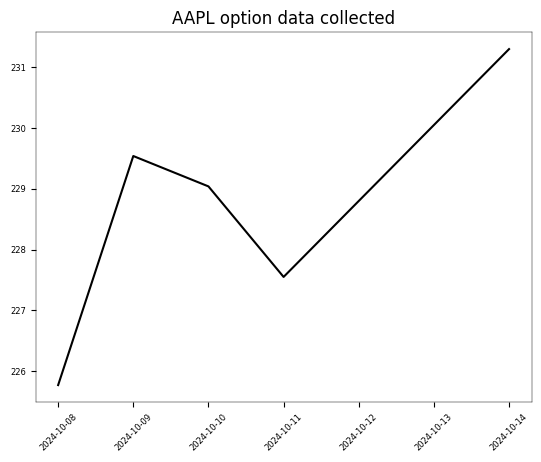

<Figure size 640x480 with 0 Axes>

In [5]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and porceed with an example calibration of our Heston (1993) model

In [6]:
date = dates[2]
raw_data = chain[date]
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
notebook_printdate = str(calculation_datetime.strftime('%A, '))+str(calculation_date)
print(notebook_printdate)

Thursday, October 10th, 2024


## modelling the volatility surface


AAPL spot price: 225.77


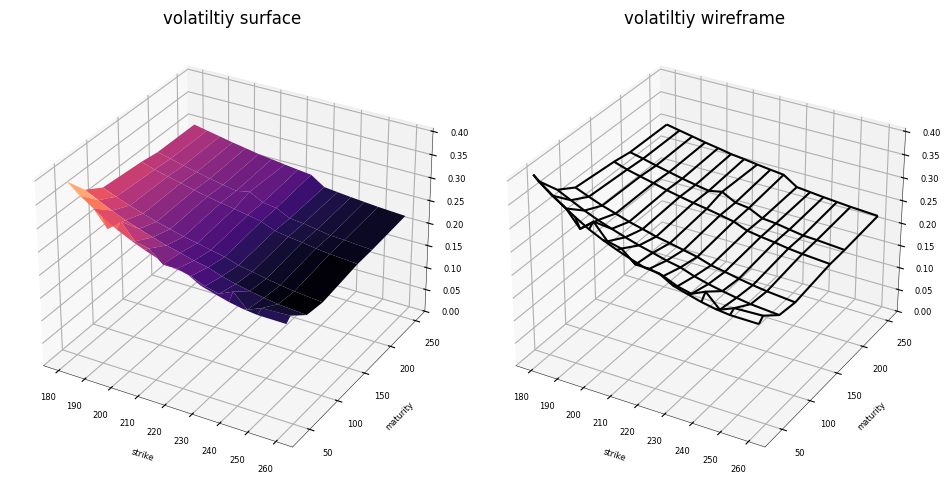

,36,43,71,99,162,189,253
180.0,0.40702,0.38659,0.33934,0.31540,0.30733,0.30138,0.30016
185.0,0.38324,0.36418,0.32531,0.30367,0.29803,0.29483,0.29437
190.0,0.36235,0.34528,0.31144,0.29269,0.29101,0.28751,0.28873
195.0,0.34299,0.31068,0.29940,0.28385,0.28431,0.28111,0.28278
200.0,0.32562,0.33446,0.28919,0.27440,0.27699,0.27470,0.27791
205.0,0.31159,0.30123,0.27958,0.26708,0.27105,0.26891,0.27242
210.0,0.29940,0.29452,0.27074,0.25916,0.26541,0.26388,0.26891
215.0,0.28873,0.26967,0.26342,0.25352,0.26068,0.26967,0.26480
220.0,0.27912,0.26906,0.25550,0.24727,0.25519,0.25428,0.26114
225.0,0.27638,0.26251,0.24970,0.24117,0.24940,0.25047,0.25778


<Figure size 640x480 with 0 Axes>

In [7]:
df = raw_data.copy()
df['volume'] = pd.to_numeric(df['volume'])
df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
df['strike'] = pd.to_numeric(df['strike'])
df['volume'] = pd.to_numeric(df['volume'])
df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
df = df[df['volume']>0].copy()
df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
indexed = df.copy().set_index(['strike','days_to_maturity'])

T = np.sort(df['days_to_maturity'].unique()).tolist()
K = np.sort(df['strike'].unique()).tolist()
volume_heatmap = pd.DataFrame(
    np.full((len(K), len(T)), np.nan), index=K, columns=T)
for k in K:
    for t in T:
        try:
            volume_heatmap.loc[k,t] = indexed.loc[(k,t),'volume']
        except Exception:
            pass
        
        
hottest_contracts = pd.DataFrame(
    volume_heatmap.unstack().sort_values(
        ascending=False)).head(50).reset_index()
hottest_contracts.columns = ['t','k','volume']
T = np.sort(hottest_contracts['t'].unique()).tolist()
K = np.sort(hottest_contracts['k'].unique()).tolist()

vol_matrix = pd.DataFrame(
    np.full((len(K),len(T)),np.nan),
    index = K,
    columns = T
)
for k in K:
    for t in T:
        try:
            vol_matrix.loc[k,t] = indexed.loc[(k,float(t)),'implied_volatility']
        except Exception:
            pass

vol_matrix = vol_matrix.dropna().copy()
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()

cols_to_map = [
        'contractID', 'symbol', 'expiration', 'type', 'last', 'mark',
        'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest', 'date',
        'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
        'spot_price', 'moneyness'
]
for col in cols_to_map:
    for i,row in hottest_contracts.iterrows():
        hottest_contracts.at[i,col] = indexed.loc[(row['k'],row['t']),col]
        
hottest_contracts = hottest_contracts.rename(
    columns={'t':'days_to_maturity','k':'strike_price'}).copy()

s = float(df['spot_price'].unique()[0])
print(f"\n{symbol} spot price: {s}")
plot_vol_surface(vol_matrix)
vol_matrix

## calibrating a Heston (1993) model

In [8]:
vol_matrix = vol_matrix.sort_index().drop_duplicates()
pd.to_numeric(raw_data['last'])
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['expiration'] = pd.to_datetime(raw_data['expiration'])
raw_data['implied_volatility'] = pd.to_numeric(raw_data['implied_volatility']).astype(float)
raw_data['strike'] = pd.to_numeric(raw_data['strike'])
raw_data['last'] = pd.to_numeric(raw_data['last'])
contract_maturities = np.array((raw_data['expiration'] - raw_data['date']) / timedelta(days=1)).astype(int)
raw_data['days_to_maturity'] = contract_maturities

T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for t in T:
    for k in K:
        p = ql.Period(int(t),ql.Days)
        volatility = vol_matrix.loc[k,t]
        helper = ql.HestonModelHelper(
            p, ms.calendar, float(s), k, 
            ql.QuoteHandle(ql.SimpleQuote(volatility)), 
            flat_ts, 
            dividend_ts
            )
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = pd.Series(
    [theta, kappa, eta, rho, v0],
    index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
    dtype = float
)
calibration_test_data = raw_data.copy()[['strike','type','last','implied_volatility','days_to_maturity']]
calibration_test_data.columns = ['strike_price','w','market_price','volatility','days_to_maturity']
calibration_test_data['spot_price'] = s
calibration_test_data['risk_free_rate'] = r
calibration_test_data['dividend_rate'] = g
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
    calibration_test_data['spot_price'].values,
    calibration_test_data['strike_price'].values,
    calibration_test_data['w'].values)
calibration_test_data['calculation_date'] = calculation_datetime
calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
avg = np.mean(np.abs(calibration_test_data['error']))
print(f"\n{printdate}\n{heston_parameters}\naverage absolute error: {round(avg,3)}")
print(f"calibration testing dataset:\n{calibration_test_data.describe()}")


Tuesday, 2024-10-08
theta    0.065619
kappa    9.874003
eta      2.152300
rho     -0.472365
v0       0.095979
dtype: float64
average absolute error: 0.85
calibration testing dataset:
       strike_price  market_price   volatility  days_to_maturity  spot_price  \
count   1242.000000   1242.000000  1242.000000       1242.000000     1242.00   
mean     190.692432     25.166377     0.404290        156.265700      225.77   
min        5.000000      0.000000     0.019100         36.000000      225.77   
25%      120.000000      0.000000     0.234118         71.000000      225.77   
50%      195.000000      0.460000     0.286365        134.000000      225.77   
75%      265.000000     23.100000     0.450310        253.000000      225.77   
max      380.000000    225.720000     4.457380        344.000000      225.77   
std       94.380821     47.030219     0.401733        103.486437        0.00   

       risk_free_rate  dividend_rate         theta        kappa           eta  \
count         

# train data generation

In [9]:
strike_spread = 0.2
K = np.linspace(
    int(s*(1-strike_spread)),
    int(s*(1+strike_spread)),
    7
).astype(int).tolist()

barrier_step = 10
down_barriers =  np.linspace(
    s*0.5,
    s*0.99,
    5
).astype(int).tolist()

T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\n\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")


AAPL spot price:
     225.77

strikes:
     [180, 195, 210, 225, 240, 255, 270]

barriers:
     [112, 140, 168, 195, 223]

maturities:
     [30, 60, 90, 180, 360, 540, 720]



In [10]:
print('generating contracts...')
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        [calculation_datetime],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'calculation_date',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
print('contracts generated')
print(f'pricing {features.shape[0]} contracts...')
features['vanilla_price'] = ms.vector_heston_price(features)
features['barrier_price'] = ms.vector_barrier_price(features)
featuresby_t = features.copy().set_index('days_to_maturity')
print('priced!')

generating contracts...
contracts generated
pricing 980 contracts...
priced!


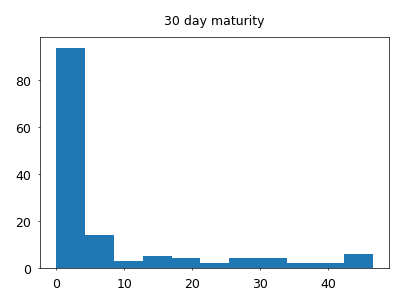

<Figure size 640x480 with 0 Axes>

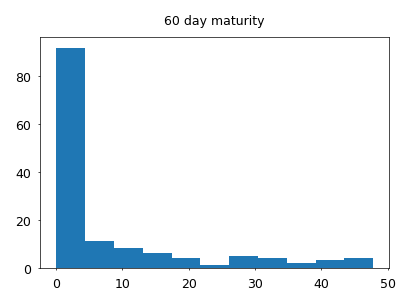

<Figure size 640x480 with 0 Axes>

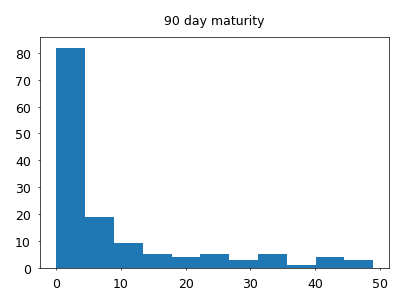

<Figure size 640x480 with 0 Axes>

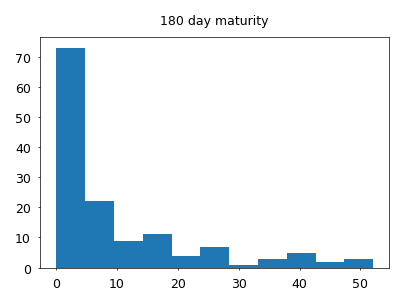

<Figure size 640x480 with 0 Axes>

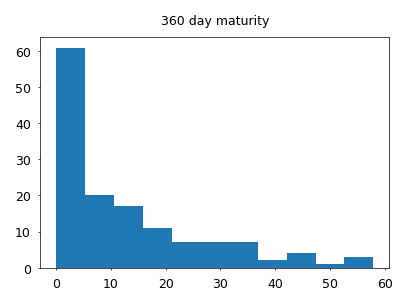

<Figure size 640x480 with 0 Axes>

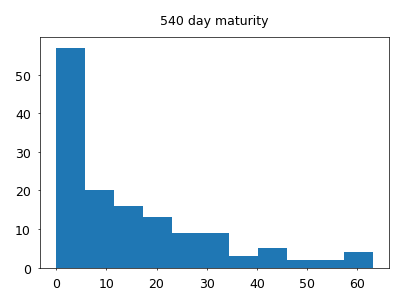

<Figure size 640x480 with 0 Axes>

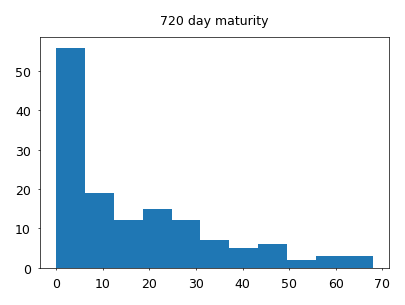

<Figure size 640x480 with 0 Axes>

In [11]:
for t in T:
    plt.figure(figsize=(3, 2), dpi=150)
    prices= featuresby_t.loc[t,'barrier_price']
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.tick_params(axis='both', which='major', length=1, width=1/3)  # Thinner tick marks
    plt.title(f'{t} day maturity', fontsize=fontsize)
    plt.show()
    plt.clf()

# model training

In [12]:
import convsklearn
help(convsklearn)

Help on package convsklearn:

NAME
    convsklearn - a proprietary package of convenience wrappers for sklearn

PACKAGE CONTENTS
    convsklearn

DATA
    barrier_trainer = <convsklearn.convsklearn.convsklearn object>
    categorical_features = ['barrier_type_name', 'w']
    feature_set = ['spot_price', 'strike_price', 'days_to_maturity', 'risk...
    numerical_features = ['spot_price', 'strike_price', 'days_to_maturity'...
    target_name = 'observed_price'
    target_transformer_pipeline = Pipeline(steps=[('StandardScaler', Stand...
    transformers = [('StandardScaler', StandardScaler(), ['spot_price', 's...

FILE
    e:\python\lib\site-packages\convsklearn\__init__.py




In [13]:
from convsklearn import target_name, numerical_features, categorical_features, transformers, target_transformer_pipeline

In [14]:
barrier_trainer = convsklearn.convsklearn(
    target_name=target_name, 
    numerical_features=numerical_features, 
    categorical_features=categorical_features, 
    transformers=transformers, 
    target_transformer_pipeline=target_transformer_pipeline, 
    max_iter=1000
)

In [18]:
features['observed_price'] = ms.noisyfier(features.loc[:,'barrier_price']) 
    # apply slight peturbation in the form of a random normal with standard deviation 0.15
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
print(f"train data count: {train_data.shape[0]}")
print(f"test data count: {test_data.shape[0]}")
arrs = barrier_trainer.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = barrier_trainer.preprocess()
dnn_barriers, runtime, specs = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
in_sample, out_of_sample, errors = barrier_trainer.test_prediction_accuracy(dnn_barriers, test_data, train_data)
outsample = out_of_sample.rename(
    columns = {
        'strike_price':'k',
        'days_to_maturity':'t',
        'barrier_type_name':'type',
        'barrier_price':'price',
        'vanilla_price':'vanilla',
        'spot_price':'spot',
        'outofsample_target':'target',
        'outofsample_prediction':'dnn',
        'outofsample_error':'error',
        'barrier':'b'
        }
)
outsample = outsample[[
    'spot', 'k', 'b','price', 'vanilla', 'type', 'w','t', 
    'target', 'dnn', 'error'
]]
print(f"\n{dnn_barriers}")

train data count: 840
test data count: 140

training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

in sample:
     RSME: 3.0293508187542137
     MAE: 2.1762109626687858

out of sample:
     RSME: 5.663211193488862
     MAE: 4.4408336578022185

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                  

In [16]:
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows",None)
print(f"\n{outsample.describe()}")
outsample_preview = outsample.copy().sort_values(by=['w','type','k','b'],ascending=False).reset_index(drop=True)
print(f"\n{symbol} down barrier options for {notebook_printdate}")
outsample_preview


        spot      k      b  price  vanilla      t  target    dnn  error
count 140.00 140.00 140.00 140.00   140.00 140.00  140.00 140.00 140.00
mean  225.77 225.00 167.60  16.51    33.02 720.00   16.53  17.05   0.53
std     0.00  30.11  39.32  17.09    16.75   0.00   17.10  13.85   6.20
min   225.77 180.00 112.00   0.00     8.76 720.00    0.00  -2.52 -17.76
25%   225.77 195.00 140.00   1.72    20.63 720.00    1.77   6.59  -4.66
50%   225.77 225.00 168.00  11.32    30.51 720.00   11.44  12.59   0.25
75%   225.77 255.00 195.00  25.43    44.38 720.00   25.34  24.22   5.26
max   225.77 270.00 223.00  68.05    68.19 720.00   68.17  60.21  15.58

AAPL down barrier options for Thursday, October 10th, 2024


,spot,k,b,price,vanilla,type,w,t,target,dnn,error
0,225.77,270,223,0.05,44.38,DownOut,put,720,0.00,-0.42,-0.42
1,225.77,270,195,2.34,44.38,DownOut,put,720,2.23,5.87,3.64
2,225.77,270,168,8.92,44.38,DownOut,put,720,8.91,12.61,3.70
3,225.77,270,140,19.32,44.38,DownOut,put,720,19.13,24.16,5.03
4,225.77,270,112,30.00,44.38,DownOut,put,720,30.21,24.38,-5.83
5,225.77,255,223,0.02,35.95,DownOut,put,720,0.24,-0.00,-0.24
6,225.77,255,195,1.19,35.95,DownOut,put,720,1.32,6.28,4.96
7,225.77,255,168,5.66,35.95,DownOut,put,720,5.67,12.56,6.89
8,225.77,255,140,13.85,35.95,DownOut,put,720,13.81,20.34,6.53
9,225.77,255,112,22.96,35.95,DownOut,put,720,23.07,19.46,-3.62


In [17]:
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format") 